In [1]:
from standardInclude import *

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


In [2]:
f = r.TFile("./deltaTCalos.root")
f.ls()
c1 = f.Get("c1")
print([x for x in c1.GetListOfPrimitives()])
deltaTCalos = c1.GetPrimitive("deltaTCalos").Clone()
deltaTCalos.SetDirectory(0)

[<ROOT.TFrame object ("TFrame") at 0x7fffe1efa1e0>, <ROOT.TH2D object ("deltaTCalos") at 0x7fffe1eff5b0>, <ROOT.TPaveText object ("title") at 0x7fffe1fb2370>]
TFile**		./deltaTCalos.root	
 TFile*		./deltaTCalos.root	
  KEY: TCanvas	c1;1	c1


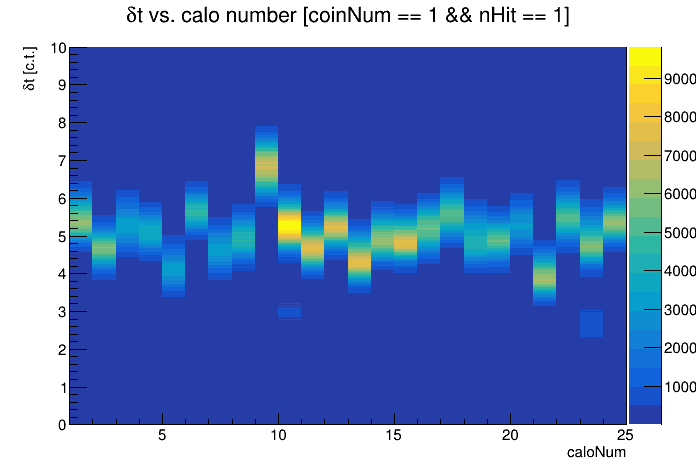

In [3]:
c = r.TCanvas()
deltaTCalos.Draw("colz")
c.Draw()

In [7]:
shape = (1,25) #shape of each row in the calorimeter matrix. 24 rows for calos + 1 for setting calo 22 offset to 0.

#create a matrix in which to store the calo values and the deltaT value
matrix = np.zeros(shape, dtype=float)
rhs = np.zeros((1,1),dtype=float)
#print(matrix, len(matrix[0]))
#print(rhs)

caloHists = []

for calo in range(1,25):
    caloBin = deltaTCalos.GetXaxis().FindBin(calo)
    hi = deltaTCalos.ProjectionY("",caloBin, caloBin).Clone("h_"+str(calo))
    c = r.TCanvas()
    hi.Draw()
    
    peak = hi.GetBinCenter(hi.GetMaximumBin())
    tempSigma = 0.4 #hi.GetRMS()
    
    func = r.TF1("func","gaus",peak-tempSigma, peak+tempSigma)
    func.SetParameters(1000,6,2)
    for sdfniwe in range(2):
        hi.Fit(func,"REMBQ")
    
    caloHists.append(hi.Clone("hi_"+str(calo)))
    #c.Draw()
    
    mean = func.GetParameter(1)
    
    #create a new row in each of the matrices and set the values accordingly
    newMatrixRow = [[0 for i in range(24)]+[1]]
    #newMatrixRow[0][(calo -1) % 24] = 1
    #newMatrixRow[0][calo % 24] = -1
    newMatrixRow[0][(calo -2) % 24] = -1
    newMatrixRow[0][(calo-1) % 24] = 1
    newRHS = [[mean]]
    #print(newMatrixRow)
    
    matrix = np.append(matrix, newMatrixRow, 0)
    rhs = np.append(rhs, newRHS, 0)
    
    #create condition to set calo 22 to 0
    if(calo == 22): 
        newMatrixRow = [[0 for i in range(24)]+[0]]
        newMatrixRow[0][(calo -1) % 24] = +1
        newRHS = [[0]]
        #print(newMatrixRow)
        matrix = np.append(matrix, newMatrixRow, 0)
        rhs = np.append(rhs, newRHS, 0)

matrix = np.delete(matrix, 0, 0)
rhs = np.delete(rhs, 0, 0)

In [8]:
print(matrix)
print(rhs)

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0. -1.  1.]
 [-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  1.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  

In [37]:
timeConstants, residuals, rankOfMatrix, singularValuesOfMatrix  = np.linalg.lstsq(matrix, rhs)

#invert time constants to match conventions
timeConstants = [-1*x for x in timeConstants]

/home/jlab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


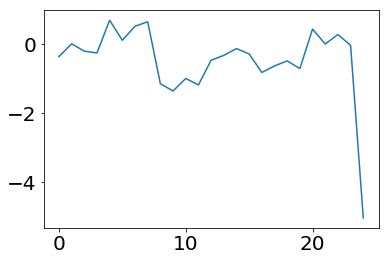

In [38]:
plt.plot(timeConstants)

In [39]:
#calculated on the virtual machines using jasons timing alignment constant values
jasonConstants = [-0.373,0.000,-0.220,-0.271,0.675,0.095,0.498,0.624,-1.168,-1.380,-1.018,-1.209,-0.490,-0.354,-0.143,-0.307,-0.846,
                  -0.670,-0.528,-0.724,0.434,-0.000,0.273,-0.044,-5.051]

In [40]:
with open('globalTimeAlignmentConstants.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=' ',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for x in timeConstants:
        spamwriter.writerow(x)

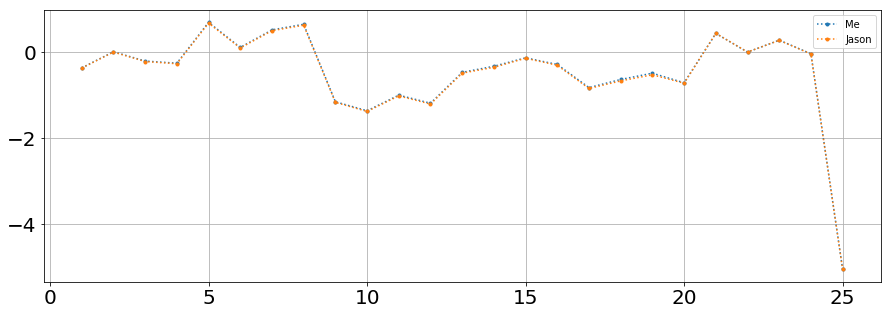

In [41]:
fig,ax = plt.subplots(figsize=(15,5))
plt.plot([x for x in range(1,26)],[float(x) for x in timeConstants], ".:",label="Me")
plt.plot([x for x in range(1,26)],jasonConstants,".:",label="Jason")
plt.legend()
plt.grid()
plt.show()

In [43]:
deltaConstants = [float(x)-y for (x,y) in zip(timeConstants,jasonConstants)]
print(deltaConstants)

[0.006407611350458919, 0.0068638091463048626, 0.011585320778340374, 0.011997500069096279, 0.015791154329295787, 0.012748831625025603, 0.017878886222572832, 0.021996102874056844, 0.012673417349772675, 0.015652918011309414, 0.01661516770358018, 0.020165568083842622, 0.01906347853445406, 0.024248363691922514, 0.009679712437250326, 0.018716438942760205, 0.019640428041969638, 0.03320702962280253, 0.037284555398277186, 0.010599089625400682, 0.0005510068712292759, 5.995204332975845e-15, 0.0032210024587662756, 0.004558215412194248, -0.002281294390988009]


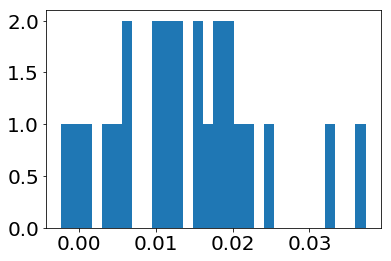

In [44]:
plt.hist(deltaConstants,bins=30)
plt.show()

In [45]:
#f2 = r.TFile("./data/gm2offline_full_allRuns_EnergyFix.root")
f2 = r.TFile("./data/gm2offline_full_runNumFix.root")
t = f2.Get("lostMuonTree/lostMuonCoincidences")

In [ ]:
deltaTCalos_Corrected = deltaTCalos.Clone("deltaTCalos_Corrected")
deltaTCalos_Corrected.Reset()

cutString = "coinNum == 1 && nHit == 1"

for calo in range(1,25):
    print("Starting calo", calo)
    deltaTCalos_i = deltaTCalos.Clone("deltaTCalos_i")
    deltaTCalos_i.Reset()
    t.Draw("deltaT + "+str(timeConstants[calo-1][0])+":caloNum>>deltaTCalos_i",
           cutString+" && caloNum == "+str(calo),
           "goff")
    deltaTCalos_Corrected.Add(deltaTCalos_i,1)

In [ ]:
deltaTCalos_JasonCorrected = deltaTCalos.Clone("deltaTCalos_JasonCorrected")
deltaTCalos_JasonCorrected.Reset()

cutString = "coinNum == 1 && nHit == 1"

for calo in range(1,25):
    print("Starting calo", calo)
    deltaTCalos_i = deltaTCalos.Clone("deltaTCalos_i")
    deltaTCalos_i.Reset()
    t.Draw("deltaT + "+str(jasonConstants[calo-1])+":caloNum>>deltaTCalos_i",
           cutString+" && caloNum == "+str(calo),
           "goff")
    deltaTCalos_JasonCorrected.Add(deltaTCalos_i,1)

In [ ]:
jasonConstants[calo-1]

In [ ]:
c = r.TCanvas()
deltaTCalos_Corrected.Draw("colz")
c.Draw()

In [ ]:
c = r.TCanvas()
deltaTCalos_JasonCorrected.Draw("colz")
c.Draw()